In [1]:
import re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import re
import pprint
from BCBio.GFF import GFFExaminer
from BCBio import GFF
from sklearn.metrics import r2_score

In [2]:
names_of_scaffolds = []
for i in range(1, 26):
    names_of_scaffolds.append('scaffold_' + str(i)) 
    
mushroom_names = ['X-9_S78', 'X-12_S79', 'X-17_S80', 'X-27_S82', 'X-30_S83',
                  'X-69_S85', 'S1_contigs', 'S2_contigs', 'S4_contigs',
                 '14-01_S62', '14-101_S73', '14-102_S74', '14-104_S75',
                  '14-112_S77', '14-11_S63', '14-24', '14-25_S64',
                  '14-29_S65', '14-31_S66', '14-32_S67', '14-34_S68',
                  '14-41', '14-67_S84', '14-70_S69', '14-85_S70',
                  '14-89_S71', '14-90_S72', '14-96', 'A10_contigs',
                  'A3_contigs', 'B3_contigs', 'B6_contigs',
                  'A7_contigs', 'B1_contigs', 'B5_contigs', 'A5_contigs',
                  'A4_contigs', 'A13_contigs','K1_contigs', 'K3_contigs', 'K4_contigs',
                  'M2_contigs', 'M3_contigs', 'K1_contigs', 'K3_contigs', 'K4_contigs',
                  'FL_contigs', 'M1_contigs', 'X-21_S81', 'X-44', '15-14_S76', 'A8_contigs',
                  'M4_contigs', 'M5_contigs', 'M6_contigs', 'Mi1_contigs', 'Mos_contigs']
                  



def get_data(mushroom_name):
    names_of_scaffolds = []
    for i in range(1, 26):
        names_of_scaffolds.append('scaffold_' + str(i)) 


    filename = 'ref_' + mushroom_name + '.maf'
    with open(filename) as fin:
        fin.seek(0) #395
        data = fin.read()
    data = data.split('\n')
    for i in range(len(data)):
        del data[0]
        if data[0] == '':
            del data[0]
            break

    lines = []
    pos_start = 0
    for x in data:
        lines.append(x.split())
    good_lines = {}
    lines = [x for x in lines if x != []] 
    for i in range(len(lines)):
        if lines[i][0] == 'a':
            scaf_name = lines[i+1][1]
            pos_start, length = lines[i+1][2], lines[i+1][3]
            if scaf_name not in good_lines.keys():
                good_lines[scaf_name] = []
        else:
            lines[i].append(pos_start)
            lines[i].append(length)
            good_lines[scaf_name].append(lines[i])
    data_fin = {}
    for name_of_scaffold in names_of_scaffolds:
        if name_of_scaffold in good_lines.keys():
            res = good_lines[name_of_scaffold]

            # leaving only necessary information
            data_fin_sc = []
            for x in res:
                if x[1].startswith('NODE'):
                    data_fin_sc.append([x[1], int(x[-2]), int(x[-2]) + int(x[-1]), x[4], int(x[2]), int(x[2]) + int(x[-1]), int(x[-1])])
            data_fin[name_of_scaffold] = data_fin_sc
    return data_fin


In [3]:
inv_df = pd.read_csv('inv_df_pairwise_all.csv',  error_bad_lines=False)
inv_df = inv_df.rename({'Unnamed: 0': 'sample'}, axis='columns')


inv_df.set_index('sample', inplace=True)
dict_inv = inv_df.to_dict()


In [4]:
fin_dict = {}
for m in dict_inv.keys():
    fin_dict[m] = {}
    for sc in dict_inv[m].keys():
        if type(dict_inv[m][sc]) is not float:
            if len(dict_inv[m][sc]) == 2:
                fin_dict[m][sc] = []
            else:
                fin_dict[m][sc] = []
                for x in dict_inv[m][sc][3:-3].split('], ['):
                    res = []
                    for y in x.split(', '):
                        if y.startswith("'"):
                            res.append(y[1:-1])
                        elif y[-1] == ']':
                            res.append(y[:-1])
                        elif y.startswith("["):
                            res.append(y[2:-1])
                        else:
                            res.append(y)
                    fin_dict[m][sc].append(res)

In [5]:
all_inv = {}
for sc in names_of_scaffolds:
    all_inv[sc] = {}
    
    
for m in fin_dict.keys():
    for sc in fin_dict[m].keys():
        for x in fin_dict[m][sc]: # every inv
            appended = 0 
            for y in all_inv[sc].keys(): # every inversion already in the list
                if abs(int(x[2]) - y) < 100:
                    if m not in all_inv[sc][y]:
                        all_inv[sc][y].append(m) 
                    appended = 1
            if appended == 0:
                all_inv[sc][int(x[2])] = [m]

In [6]:
len(fin_dict.keys())

54

In [7]:
for key1 in all_inv['scaffold_10']:
    for key2 in all_inv['scaffold_10']:
        if key1 != key2:
            if abs(key1 - key2) < 100:
                print(key1, key2)

In [8]:
all_inv_listed = {}
for sc in all_inv.keys():
    for c in all_inv[sc].keys():
        all_inv_listed[sc + '_' + str(c)] = all_inv[sc][c]

In [9]:
all_inv_freq = {}
for k in all_inv_listed.keys():
    all_inv_freq[k] = len(all_inv_listed[k])

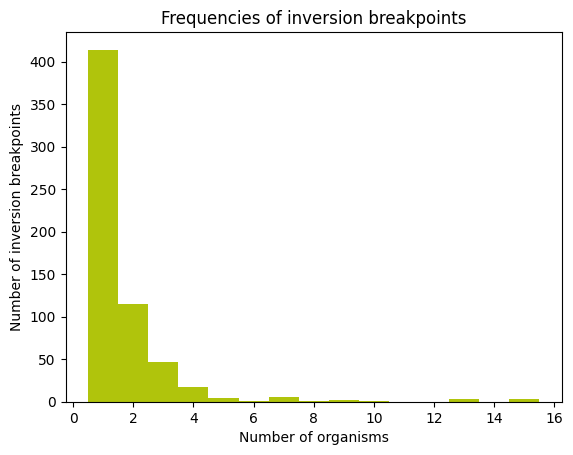

In [10]:
plt.hist(all_inv_freq.values(), bins=np.arange(0,16)+0.5, color = "#b0c40c")
plt.title('Frequencies of inversion breakpoints')
plt.xlabel('Number of organisms')
plt.ylabel('Number of inversion breakpoints')
plt.show()

In [11]:
origin = {}
for name in fin_dict.keys():
    if name[0] in ['A', 'B', '1']:
        origin[name] = 'a'
    else:
        origin[name] = 'r'
        
        
origin['s1514'] = 'a'
origin['FL_contigs'] = 'a'
origin['Mi1'] = 'a'

In [12]:
len(fin_dict.keys())

54

In [13]:
am_inv_freq = {}
rus_inv_freq = {}
for k in all_inv_listed.keys():
    rus_inv_freq[k] = 0
    am_inv_freq[k] = 0
    for x in all_inv_listed[k]:
        if origin[x] == 'r':
            rus_inv_freq[k] += 1
        else:
            am_inv_freq[k] += 1
am_inv_freq = {k: v for k, v in am_inv_freq.items() if v != 0}
rus_inv_freq = {k: v for k, v in rus_inv_freq.items() if v != 0}

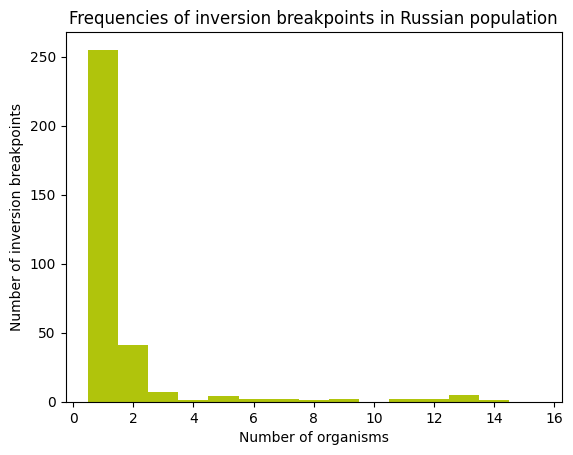

In [14]:
plt.hist(rus_inv_freq.values(), bins=np.arange(0,16)+0.5, color = "#b0c40c")
plt.title('Frequencies of inversion breakpoints in Russian population')
plt.xlabel('Number of organisms')
plt.ylabel('Number of inversion breakpoints')
plt.show()

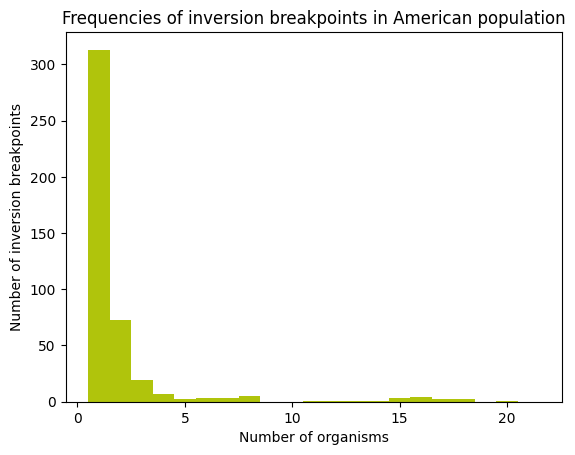

In [15]:
plt.hist(am_inv_freq.values(), bins=np.arange(0,22)+0.5, color = "#b0c40c")
plt.title('Frequencies of inversion breakpoints in American population')
plt.xlabel('Number of organisms')
plt.ylabel('Number of inversion breakpoints')
plt.show()

In [16]:
len(all_inv_freq)

629

# checking if we know at least some lengths

In [17]:
fin_dict_paired = {}
for m in fin_dict.keys():
    fin_dict_paired[m] = {}
    for sc in fin_dict[m].keys():
        fin_dict_paired[m][sc] = []
        for i in range(len(fin_dict[m][sc])//2):
            res = [fin_dict[m][sc][i*2], fin_dict[m][sc][i*2+1]]
            fin_dict_paired[m][sc].append(res)

In [18]:
lengths = {}
num_inv = 0

for m in fin_dict_paired.keys():
    lengths[m] = []
    for sc in fin_dict_paired[m].keys():     
        used = []
        for bp1 in fin_dict_paired[m][sc]:
            for bp2 in fin_dict_paired[m][sc]:
                if bp1 != bp2:
                    if bp1[0][0] == bp2[0][0]:
                        if bp1[0][3] != bp2[0][3]:
                            if bp1 not in used and bp2 not in used:
                                used.append(bp1)
                                used.append(bp2)
                                length = abs(int(bp1[0][2]) - int(bp2[0][2]))
                                lengths[m].append(length)
                                num_inv += 1

In [19]:
lengths_list = []
lengths_r = []
lengths_am = []

for m in lengths.keys():
    if len(lengths[m]) != 0:
        for x in lengths[m]:
            lengths_list.append(x)
            if origin[m] == 'r':
                lengths_r.append(x)
            else:
                lengths_am.append(x)

In [20]:
np.mean(lengths_list)

5898.14705882353

In [21]:
np.median(lengths_list)

666.0

In [22]:
len(lengths_list)

34

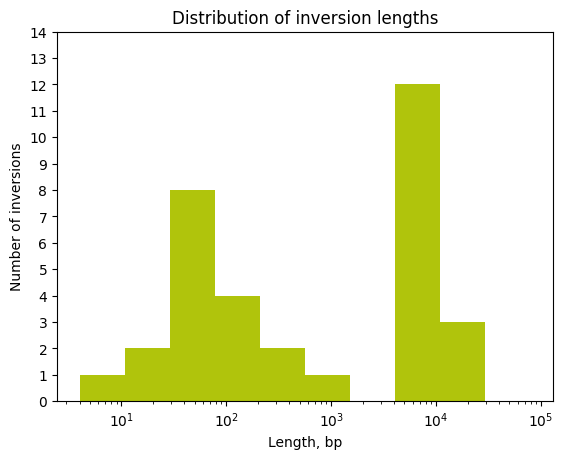

In [23]:
def plot_loghist(x, bins):
  hist, bins = np.histogram(x, bins=bins)
  logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
  plt.hist(x, bins=logbins,  color = "#b0c40c")
  plt.xscale('log')

plot_loghist(lengths_list, 10)



plt.title("Distribution of inversion lengths")
plt.ylabel('Number of inversions')
plt.xlabel('Length, bp')
plt.yticks(range(0, 15, 1))
plt.show()

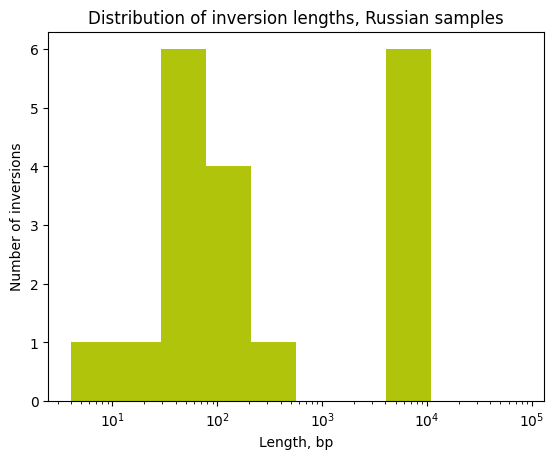

In [24]:
plot_loghist(lengths_r, 10)
plt.title("Distribution of inversion lengths, Russian samples")
plt.ylabel('Number of inversions')
plt.xlabel('Length, bp')
plt.show()

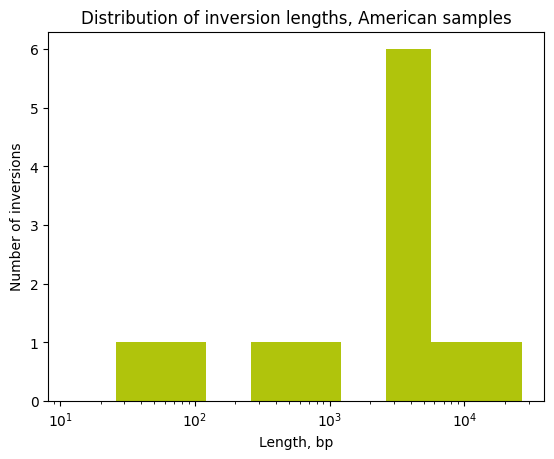

In [25]:
plot_loghist(lengths_am, 10)
plt.title("Distribution of inversion lengths, American samples")
plt.ylabel('Number of inversions')
plt.xlabel('Length, bp')
plt.show()

In [26]:
num_rus = 0
for m in origin.keys():
    if origin[m] == 'r':
        num_rus +=1
print(num_rus)

22


In [27]:
with open('ref.fasta.out') as fin:
    data = fin.read()

In [29]:
data = data.split('\n')

In [30]:
data = data[3:]

In [31]:
data = [' '.join(x.split()) for x in data]

In [32]:
data = [x.split(' ') for x in data]

In [33]:
data.remove([''])

In [34]:
with open('dustmasker_res.txt') as fin:
    data2 = fin.read()

In [35]:
data2 = data2.split('\n')

In [36]:
data2 = [' '.join(x.split(' - ')) for x in data2]

In [37]:
dict_rep = {}
for line in data2:
    if line.startswith('>'):
        sc = line[1:]
        dict_rep[sc] = []
    else:
        dict_rep[sc].append(line.split(' '))

In [38]:
repeats = {}
num = 500
for m in fin_dict_paired.keys():
    repeats[m] = {}
    for sc in fin_dict_paired[m].keys():
        repeats[m][sc] = {}
        for x in fin_dict_paired[m][sc]:
            coord = np.mean([int(x[0][2]), int(x[1][1])])
            repeats[m][sc][coord] = ''
            for line in dict_rep[sc]:
                    if int(line[0]) - num < coord:
                        if int(line[1]) + num > coord:
                            repeats[m][sc][coord] = 'repeat'

In [72]:
data2

['>scaffold_1',
 '0 140',
 '2599 2604',
 '4307 4312',
 '7287 7350',
 '7578 7641',
 '7730 7805',
 '7824 7887',
 '7922 7983',
 '9234 9239',
 '10529 10534',
 '12401 12463',
 '13357 13435',
 '13560 13658',
 '14914 14968',
 '16320 16325',
 '17095 17159',
 '17214 17255',
 '17283 17338',
 '17400 17523',
 '17532 17601',
 '19052 19058',
 '20363 20368',
 '20513 20630',
 '20851 20891',
 '23630 23635',
 '23784 23855',
 '24121 24126',
 '24556 24620',
 '25559 25564',
 '27520 27526',
 '29899 29959',
 '30186 30249',
 '30412 30455',
 '30537 30601',
 '30649 30719',
 '30869 30940',
 '31182 31464',
 '31512 31517',
 '31593 31648',
 '31726 31947',
 '31984 32068',
 '32078 32374',
 '32428 32433',
 '32703 32730',
 '32836 32892',
 '33125 33279',
 '34757 34762',
 '36127 36186',
 '38001 38006',
 '39044 39164',
 '43020 43025',
 '43431 43497',
 '45350 45416',
 '45609 45696',
 '46453 46523',
 '46558 46646',
 '46863 46953',
 '47118 47182',
 '47280 47630',
 '47688 47853',
 '47864 47951',
 '47972 48123',
 '48263 48309'

In [73]:
repeats = {}
num = 500
for m in fin_dict_paired.keys():
    repeats[m] = {}
    for sc in fin_dict_paired[m].keys():
        repeats[m][sc] = {}
        for x in fin_dict_paired[m][sc]:
            coord = np.mean([int(x[0][2]), int(x[1][1])])
            repeats[m][sc][coord] = ''
            for line in data:
                if line[4] == sc:

                    if int(line[5]) - num < coord:
                        if int(line[6]) + num > coord:
                            repeats[m][sc][coord] = line[10]

In [91]:
repeats

{'X-21_S81': {'scaffold_1': {2363747.0: '', 4275579.0: 'repeat'},
  'scaffold_2': {3746128.0: 'repeat'},
  'scaffold_3': {1168430.5: 'repeat', 1186687.0: 'repeat'},
  'scaffold_4': {},
  'scaffold_5': {},
  'scaffold_6': {1111075.0: 'repeat',
   1124288.5: 'repeat',
   1151235.5: 'repeat'},
  'scaffold_7': {1854227.5: '', 568735.5: 'repeat', 2422038.5: 'repeat'},
  'scaffold_8': {2331100.5: 'repeat', 2331133.5: 'repeat'},
  'scaffold_9': {},
  'scaffold_10': {851886.0: '',
   851824.5: '',
   856661.0: 'repeat',
   856643.5: 'repeat',
   856823.5: 'repeat',
   1680576.0: 'repeat'},
  'scaffold_11': {},
  'scaffold_12': {},
  'scaffold_13': {8715.5: 'repeat', 59007.5: 'repeat', 58944.0: 'repeat'},
  'scaffold_14': {2078.5: 'repeat'},
  'scaffold_15': {},
  'scaffold_16': {},
  'scaffold_17': {},
  'scaffold_18': {},
  'scaffold_19': {},
  'scaffold_20': {},
  'scaffold_21': {},
  'scaffold_22': {},
  'scaffold_23': {},
  'scaffold_24': {},
  'scaffold_25': {}},
 'X-44': {'scaffold_1': {

# Only real inversions

In [39]:
fin_dict_paired = {}
for m in fin_dict.keys():
    fin_dict_paired[m] = {}
    for sc in fin_dict[m].keys():
        fin_dict_paired[m][sc] = []
        for i in range(len(fin_dict[m][sc])//2):
            fin_dict_paired[m][sc].append([fin_dict[m][sc][i*2],  fin_dict[m][sc][i*2+1]])

In [40]:
fin_dict_paired

{'X-21_S81': {'scaffold_1': [[['NODE_1039_length_4127_cov_31.5432_ID_330594',
     '2363640',
     '2363741',
     '+',
     '2100',
     '2201',
     '101'],
    ['NODE_1039_length_4127_cov_31.5432_ID_330594',
     '2363753',
     '2363974',
     '-',
     '1900',
     '2121',
     '221']],
   [['NODE_1402_length_1977_cov_24.2768_ID_331324',
     '4275441',
     '4275571',
     '+',
     '1841',
     '1971',
     '130'],
    ['NODE_1402_length_1977_cov_24.2768_ID_331324',
     '4275587',
     '4275869',
     '-',
     '1570',
     '1852',
     '282']]],
  'scaffold_2': [[['NODE_4180_length_151_cov_29.2838_ID_336872',
     '3746046',
     '3746136',
     '-',
     '56',
     '146',
     '90'],
    ['NODE_4180_length_151_cov_29.2838_ID_336872',
     '3746120',
     '3746188',
     '+',
     '0',
     '68',
     '68']]],
  'scaffold_3': [[['NODE_1403_length_1975_cov_106.061_ID_331326',
     '1168117',
     '1168435',
     '+',
     '1541',
     '1859',
     '318'],
    ['NODE_1403_length

In [41]:
repeats

{'X-21_S81': {'scaffold_1': {2363747.0: '', 4275579.0: 'repeat'},
  'scaffold_2': {3746128.0: 'repeat'},
  'scaffold_3': {1168430.5: 'repeat', 1186687.0: 'repeat'},
  'scaffold_4': {},
  'scaffold_5': {},
  'scaffold_6': {1111075.0: 'repeat',
   1124288.5: 'repeat',
   1151235.5: 'repeat'},
  'scaffold_7': {1854227.5: '', 568735.5: 'repeat', 2422038.5: 'repeat'},
  'scaffold_8': {2331100.5: 'repeat', 2331133.5: 'repeat'},
  'scaffold_9': {},
  'scaffold_10': {851886.0: '',
   851824.5: '',
   856661.0: 'repeat',
   856643.5: 'repeat',
   856823.5: 'repeat',
   1680576.0: 'repeat'},
  'scaffold_11': {},
  'scaffold_12': {},
  'scaffold_13': {8715.5: 'repeat', 59007.5: 'repeat', 58944.0: 'repeat'},
  'scaffold_14': {2078.5: 'repeat'},
  'scaffold_15': {},
  'scaffold_16': {},
  'scaffold_17': {},
  'scaffold_18': {},
  'scaffold_19': {},
  'scaffold_20': {},
  'scaffold_21': {},
  'scaffold_22': {},
  'scaffold_23': {},
  'scaffold_24': {},
  'scaffold_25': {}},
 'X-44': {'scaffold_1': {

In [42]:
real_inv = {}
cs = []
for m in fin_dict_paired.keys():
    real_inv[m] = {}
    data = get_data(m)
    for sc in fin_dict_paired[m].keys():
        real_inv[m][sc] = []
        for x in fin_dict_paired[m][sc]:
            coord = np.mean([int(x[0][2]), int(x[1][1])])
            c = 0
            for line in data[sc]:
                #if abs(line[1] - coord) < 30 or abs(line[2] - coord) < 30:
                if line[1] < coord:
                    if line[2] > coord:
                        c += 1
            cs.append([c, repeats[m][sc][coord]])
            if c < 3:
                real_inv[m][sc].append(x)
                

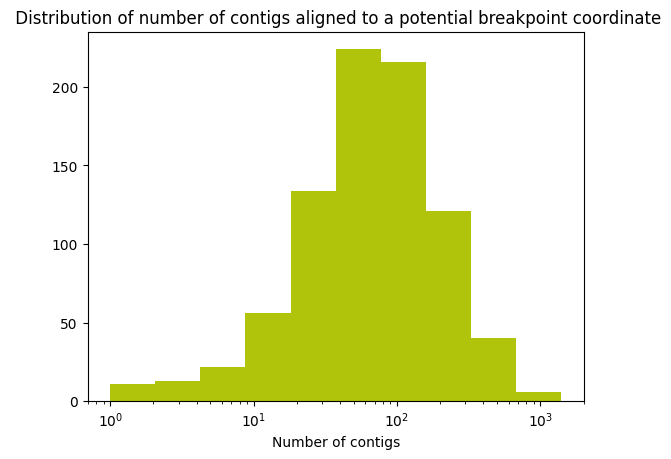

In [62]:
def plot_loghist(x, bins):
  hist, bins = np.histogram(x, bins=bins)
  logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
  plt.hist(x, bins=logbins,  color = "#b0c40c")
  plt.xscale('log')

cs_1 = [x[0] for x in cs if x[0] != 0]
plt.xlabel('Number of contigs')
plt.title(' Distribution of number of contigs aligned to a potential breakpoint coordinate')
plot_loghist(cs_1, 10)
plt.show()

In [59]:
cs_no_repeats = [x[0] for x in cs if x[1]=='']
cs_repeats = [x[0] for x in cs if x[1]!='']

cs_repeats = [x for x in cs_repeats if x!=0]
cs_no_repeats = [x for x in cs_no_repeats if x!=0]

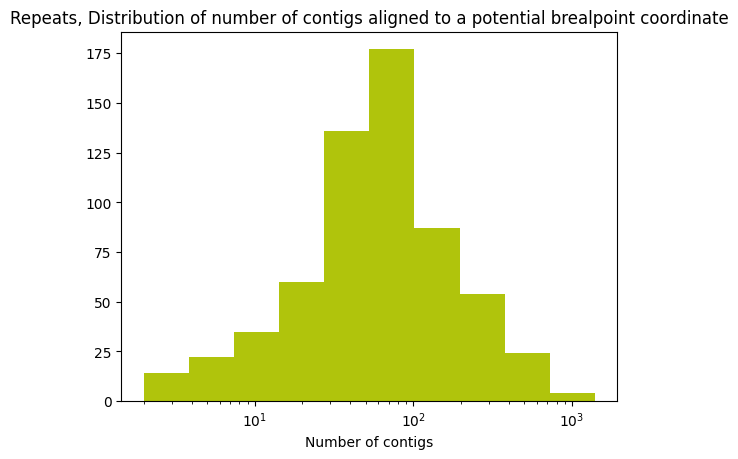

In [45]:
def plot_loghist(x, bins):
  hist, bins = np.histogram(x, bins=bins)
  logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
  plt.hist(x, bins=logbins,  color = "#b0c40c")
  plt.xscale('log')

cs_1 = [x for x in cs_repeats if x != 0]
plt.xlabel('Number of contigs')
plt.title('Repeats, Distribution of number of contigs aligned to a potential brealpoint coordinate')
plot_loghist(cs_1, 10)
plt.show()

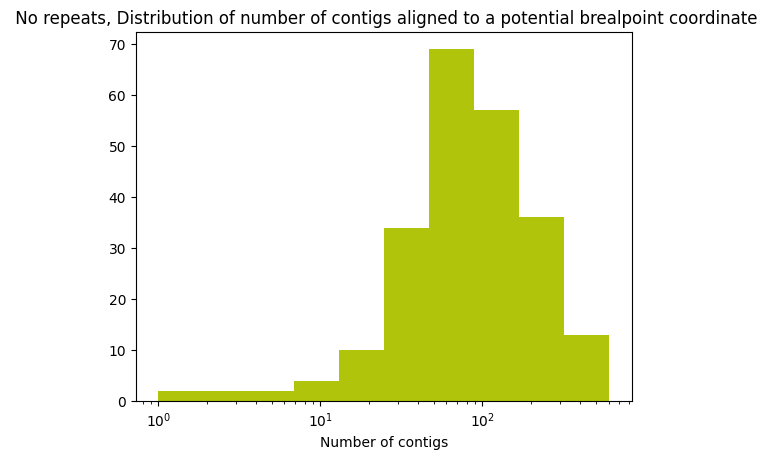

In [46]:
def plot_loghist(x, bins):
  hist, bins = np.histogram(x, bins=bins)
  logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
  plt.hist(x, bins=logbins,  color = "#b0c40c")
  plt.xscale('log')

cs_1 = [x for x in cs_no_repeats if x != 0]
plt.xlabel('Number of contigs')
plt.title(' No repeats, Distribution of number of contigs aligned to a potential brealpoint coordinate')
plot_loghist(cs_1, 10)
plt.show()

In [47]:
len(cs_repeats)

616

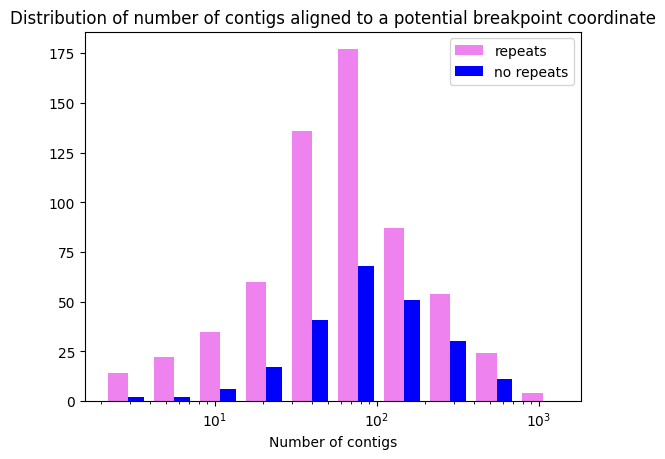

In [61]:
bins = 10
x = [cs_repeats, cs_no_repeats]
hist, bins = np.histogram(x[0], bins=bins)
logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
plt.hist(x, bins=logbins,  color=['violet', 'blue'], label = ['repeats', 'no repeats'])
plt.xscale('log')
plt.xscale('log')
plt.xlabel('Number of contigs')
plt.title('Distribution of number of contigs aligned to a potential breakpoint coordinate')
plt.legend()
plt.show()

In [ ]:
for c in cs:
    if c[0] < 3:
        print(c)

In [ ]:
real_inv_df = pd.DataFrame(real_inv)
#real_inv_df.to_csv('real_inv_df_pairwise_all.csv')

# Reading real inversion

In [ ]:
real_inv_df = pd.read_csv('real_inv_df_pairwise_all.csv',  error_bad_lines=False)
real_inv_df = real_inv_df.rename({'Unnamed: 0': 'sample'}, axis='columns')


real_inv_df.set_index('sample', inplace=True)
dict_inv = real_inv_df.to_dict()

In [ ]:
fin_dict = {}
for m in dict_inv.keys():
    fin_dict[m] = {}
    for sc in dict_inv[m].keys():
        if type(dict_inv[m][sc]) is not float:
            if len(dict_inv[m][sc]) == 2:
                fin_dict[m][sc] = []
            else:
                fin_dict[m][sc] = []
                for x in dict_inv[m][sc][3:-3].split('], ['):
                    res = []
                    for y in x.split(', '):
                        if y.startswith("'"):
                            res.append(y[1:-1])
                        elif y[-1] == ']':
                            res.append(y[:-1])
                        elif y.startswith("["):
                            res.append(y[2:-1])
                        else:
                            res.append(y)
                    fin_dict[m][sc].append(res)

In [ ]:
fin_dict_paired = {}
for m in fin_dict.keys():
    fin_dict_paired[m] = {}
    for sc in fin_dict[m].keys():
        fin_dict_paired[m][sc] = []
        for i in range(len(fin_dict[m][sc])//2):
            res = [fin_dict[m][sc][i*2], fin_dict[m][sc][i*2+1]]
            fin_dict_paired[m][sc].append(res)

In [ ]:
real_inv = fin_dict_paired

In [ ]:
real_inv


In [ ]:
def rear_search(datum):
    data = datum
    inv = []
    used_bps = []
    for i in range(len(data)):
        for j in range(len(data)):
            if data[i][0] == data[j][0]:
                if data[i][3] != data[j][3]:
                    #print('inv')
                    if (abs(data[i][1] - data[j][2]) < 30) or (abs(data[j][1] - data[i][2]) < 30):
                        if (data[i][-1] > 30) and (data[j][-1] > 30):
                            if (data[i][1] < data[j][1]):
                                if data[i] not in used_bps and data[j] not in used_bps:
                                    already_in_list = 0
                                    for x in inv:
                                        #print(x, data[i])
                                        if abs(x[0][1] - data[i][1]) < 30 or abs(x[1][1] - data[j][1]) < 30:
                                            already_in_list = 1
                                    if already_in_list == 0:
                                        inv.append([data[i], data[j]])
                                    used_bps.append(data[i])
                                    used_bps.append(data[j])
    return inv

In [36]:
state = {}
for m1 in fin_dict.keys():
    print(m1)
    state[m1] = {}
    data = get_data(m1)
    for m in real_inv.keys():
        for sc in real_inv[m].keys():
            if real_inv[m][sc] != []:
                coord = np.mean([int(real_inv[m][sc][0][0][2]), int(real_inv[m][sc][0][1][1])])
                state[m1][sc + '_' + str(coord)] = 3
                
                # checking if there is one good contig covering breakpoint
                for line in data[sc]:
                    if coord > (int(line[1]) + 30) and coord < (int(line[2]) - 30):
                        state[m1][sc + '_' + str(coord)] = -1
                        
                # checking if there is a rearrangment breakpoint
                int_lines = []
                for line in data[sc]:
                    if ((coord > int(line[1]) + 30) and coord < (int(line[2]) - 30)) or abs(coord - line[1]) < 100 or abs(coord - line[2]) < 100:
                        if line not in int_lines:
                            int_lines.append(line)
                rear = rear_search(int_lines)
                if rear != []:
                    if state[m1][sc + '_' + str(coord)] != -1:
                        state[m1][sc + '_' + str(coord)] = 2
                
                #real inv:
                if m1 == m and state[m1][sc + '_' + str(coord)] != -1:
                    state[m1][sc + '_' + str(coord)] = 1
                
                
                if int_lines == []:
                    state[m1][sc + '_' + str(coord)] = 0

X-21_S81


KeyboardInterrupt: 

*0 - no alignment
*1 - inv bp
*2 - rear bp
*3 - something weird
*-1 - for sure no inv

In [ ]:
state_df = pd.DataFrame(state)
state_df.to_csv('state_df_pairwise_all.csv')

# Reading state

In [6]:
state_df = pd.read_csv('state_df_pairwise_all.csv',  error_bad_lines=False)
state_df = state_df.rename({'Unnamed: 0': 'sample'}, axis='columns')


state_df.set_index('sample', inplace=True)
state = state_df.to_dict()

In [7]:
meaning = {-1: 'no inversion', 1: 'inversion', 2: 'rearrangment', 0: 'no data', 3: 'unclassified'}

In [8]:
for x in list(state_df.columns):
    state_df.replace({x: meaning},inplace=True)

In [9]:
state_df = state_df.drop(['scaffold_10_852816.5'])


In [10]:
pd.set_option('display.max_columns', 9)

In [11]:
state_df = state_df.drop(['scaffold_6_1652885.5'])

In [12]:
state_df = state_df.drop(['scaffold_9_243890.5'])

In [13]:
state_dfto_csv('state_df_pairwise_all.csv')

,X-21_S81,X-44,15-14_S76,A8_contigs,...,M2_contigs,M3_contigs,FL_contigs,M1_contigs
sample,,,,,,,,,
scaffold_10_1680576.0,inversion,unclassified,unclassified,unclassified,...,rearrangment,unclassified,unclassified,no inversion
scaffold_4_2802679.0,unclassified,unclassified,no inversion,unclassified,...,rearrangment,rearrangment,no inversion,unclassified
scaffold_3_103083.5,rearrangment,rearrangment,rearrangment,unclassified,...,rearrangment,rearrangment,rearrangment,rearrangment
scaffold_4_2967204.0,rearrangment,unclassified,no inversion,no inversion,...,rearrangment,rearrangment,no inversion,unclassified
scaffold_4_3460175.5,no inversion,no inversion,no inversion,unclassified,...,no inversion,unclassified,no inversion,no inversion
scaffold_2_592743.5,no inversion,no inversion,no inversion,no inversion,...,no inversion,no inversion,no inversion,no inversion
scaffold_3_859902.0,no inversion,no inversion,no inversion,rearrangment,...,rearrangment,rearrangment,rearrangment,unclassified
scaffold_4_90163.5,no data,no data,no inversion,no inversion,...,no data,no data,no inversion,no data
scaffold_12_478927.0,rearrangment,unclassified,unclassified,no inversion,...,unclassified,unclassified,no inversion,unclassified


In [36]:
v_state =state_df.apply(pd.Series.value_counts, axis=1).fillna(0)


In [37]:
v_state.index = np.arange(1, len(v_state) + 1)

In [38]:
v_state

,inversion,no data,no inversion,rearrangment,unclassified
1,1.0,0.0,6.0,1.0,46.0
2,1.0,0.0,8.0,8.0,37.0
3,1.0,3.0,0.0,45.0,5.0
4,1.0,0.0,29.0,19.0,5.0
5,1.0,0.0,43.0,0.0,10.0
6,1.0,0.0,40.0,12.0,1.0
7,1.0,0.0,24.0,23.0,6.0
8,1.0,34.0,11.0,2.0,6.0
9,1.0,0.0,17.0,10.0,26.0
10,1.0,0.0,25.0,21.0,7.0


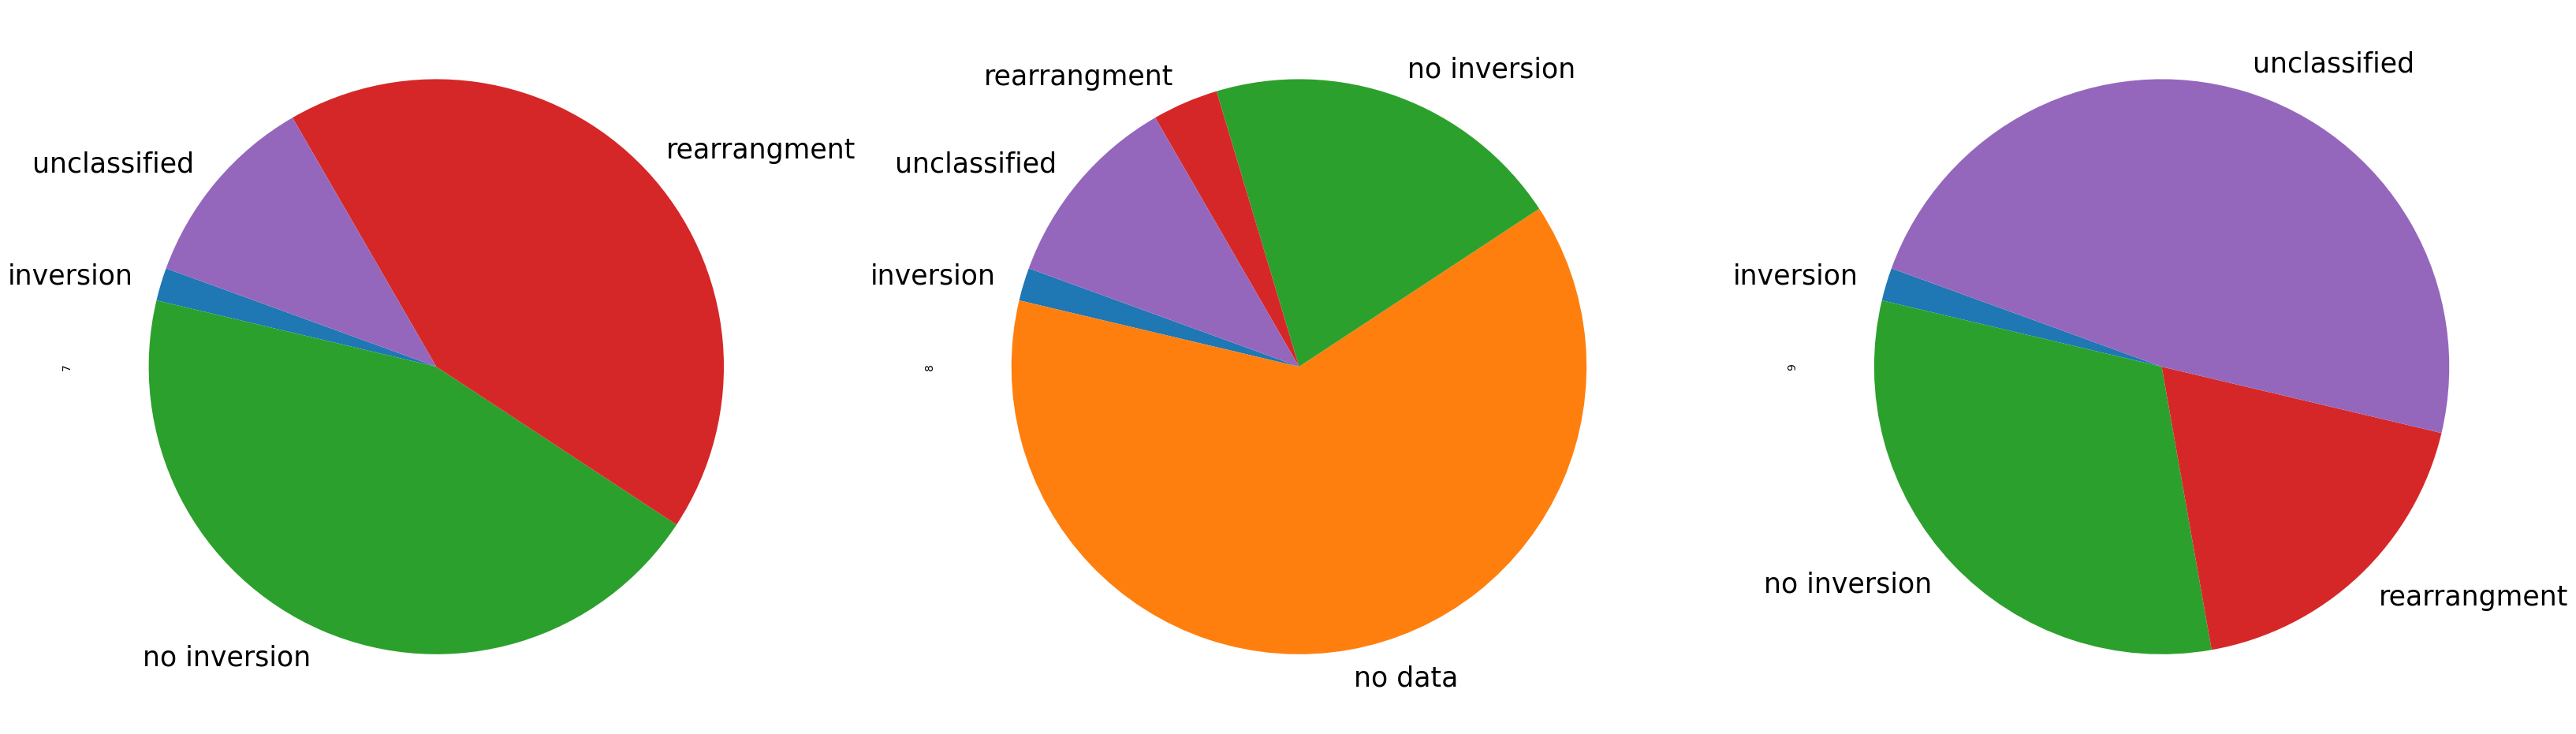

In [48]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (40,20)
v_state.loc[[7, 8,
             9]].T.plot.pie(subplots=True, legend=None, textprops={'fontsize': 25}, startangle=-200)
plt.show()


In [65]:
r_inv = []
for x in list(state_df.index):
    r_inv.append(x.split('_')[1:])

In [66]:
r_inv

[['10', '1680576.0'],
 ['4', '2802679.0'],
 ['3', '103083.5'],
 ['4', '2967204.0'],
 ['4', '3460175.5'],
 ['2', '592743.5'],
 ['3', '859902.0'],
 ['4', '90163.5'],
 ['12', '478927.0'],
 ['3', '3232677.5'],
 ['14', '304911.0'],
 ['7', '318993.0'],
 ['14', '955987.0']]

In [67]:
in_file = "Schco3.filtered_proteins.FilteredModels1.gff3"
examiner = GFFExaminer()
in_handle = open(in_file)
pprint.pprint(examiner.available_limits(in_handle))
in_handle.close()

{'gff_id': {('scaffold_1',): 27890,
            ('scaffold_10',): 11043,
            ('scaffold_11',): 9249,
            ('scaffold_12',): 8306,
            ('scaffold_13',): 6140,
            ('scaffold_14',): 6104,
            ('scaffold_15',): 3612,
            ('scaffold_16',): 3196,
            ('scaffold_17',): 3404,
            ('scaffold_18',): 2792,
            ('scaffold_19',): 498,
            ('scaffold_2',): 24656,
            ('scaffold_20',): 384,
            ('scaffold_21',): 253,
            ('scaffold_22',): 254,
            ('scaffold_23',): 181,
            ('scaffold_24',): 30,
            ('scaffold_25',): 12,
            ('scaffold_3',): 18568,
            ('scaffold_4',): 19431,
            ('scaffold_5',): 21381,
            ('scaffold_6',): 15691,
            ('scaffold_7',): 13525,
            ('scaffold_8',): 14776,
            ('scaffold_9',): 13632},
 'gff_source': {('prediction',): 225008},
 'gff_source_type': {('prediction', 'CDS'): 83643,
              

In [68]:
genes = {}
for scaffold_name in names_of_scaffolds:
    sc = 'scaffold_' + re.findall('[0-9]+', scaffold_name)[0]
    limit_info = dict(gff_id=[sc], gff_type=['gene'])
    gene_locs = []

    in_handle = open(in_file)
    for rec in GFF.parse(in_handle, limit_info=limit_info):
        feature = rec.features
        for seq in feature:
            gene_locs.append(seq.location)
    in_handle.close()
    gene_coords = []
    for loc in gene_locs:
        gene_coords.append([int(loc.start), int(loc.end)])
    genes[scaffold_name] = gene_coords

In [69]:
inv_breaking_genes = []
for sc in all_inv.keys():
    for gene in genes[sc]:
        for line in r_inv:
            if 'scaffold_' + line[0] == sc:
                c = float(line[1])
                if gene[0] < c and gene[1] > c:
                    print (sc, c)

scaffold_2 592743.5
scaffold_2 592743.5
scaffold_3 3232677.5
scaffold_4 2802679.0
scaffold_7 318993.0
scaffold_14 955987.0


In [ ]:
len(inv_breaking_genes)

## Some examples

In [41]:
def plot(m, sc, coord, num=100):
    data = get_data(m)
    int_lines = []
    for line in data[sc]:
        if ((coord > int(line[1]) + 30) and coord < (int(line[2]) - 30)) or abs(coord - line[1]) < num or abs(coord - line[2]) < num:
            if line not in int_lines:
                int_lines.append(line)
    
    int_lines = sorted(int_lines, key=lambda x: x[0])
    cs = []
    for line in int_lines:
        cs.append([line[1], line[2]])
    
    #plt.figure(figsize=(10, 10))
    col = {}
    plt.vlines(x=coord, ymin=0, ymax=len(cs), color='black')
    for i in range(len(cs)):
        if int_lines[i][0] not in col.keys():
            col[int_lines[i][0]] = list(np.random.choice(range(255),size=3))

        if int_lines[i][3] == '+':
            plt.hlines(y=i, xmin=cs[i][0], xmax=cs[i][1], color=[col[int_lines[i][0]]])
        else:
            plt.hlines(y=i, xmin=cs[i][0], xmax=cs[i][1], color=[col[int_lines[i][0]]], linestyles='dashed')
    plt.xlabel('scaffold coordinate')
    plt.show()

In [42]:
def diag_plot(m, sc, coord, num=100, reg=1, contig_name=''):
    data = get_data(m)
    int_lines = []
    for line in data[sc]:
        if ((coord > int(line[1]) + 30) and coord < (int(line[2]) - 30)) or abs(coord - line[1]) < num or abs(coord - line[2]) < num:
            if line not in int_lines:
                int_lines.append(line)
                
            
    if contig_name != '':
        int_lines = [x for x in int_lines if x[0] == contig_name]
    
    int_lines = sorted(int_lines, key=lambda x: x[0])
    cs = []
    for line in int_lines:
        cs.append([line[1], line[2], line[-3], line[-2]])
        

        
    #plt.figure(figsize=(10, 10))
    col = {}
    for i in range(len(cs)):
        if int_lines[i][0] not in col.keys():
            col[int_lines[i][0]] = list(np.random.choice(range(255),size=3))

        if int_lines[i][3] == '+':
            plt.plot(cs[i][:2], cs[i][2:], c='b')
        else:
            cs[i][2] = cs[i][2] + int_lines[i][-1]
            cs[i][3] = cs[i][3] - int_lines[i][-1]
            plt.plot(cs[i][:2], cs[i][2:], c='b')
    plt.xlabel('scaffold coordinate')
    plt.ylabel('contig coordinate')
    if reg == 1:
        plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

In [43]:
def interesting_lines(m, sc, coord, num=100):
    data = get_data(m)
    int_lines = []
    for line in data[sc]:
        if ((coord > int(line[1]) + 30) and coord < (int(line[2]) - 30)) or abs(coord - line[1]) < num or abs(coord - line[2]) < num:
            if line not in int_lines:
                int_lines.append(line)
    return int_lines

# 1 - inversion

# 1

In [65]:
state_df.loc['scaffold_10_1680576.0']

X-21_S81          inversion
X-44           unclassified
15-14_S76      unclassified
A8_contigs     unclassified
M4_contigs     unclassified
M5_contigs     unclassified
M6_contigs     unclassified
Mi1_contigs    unclassified
Mos_contigs    unclassified
X-9_S78        unclassified
X-12_S79       unclassified
X-17_S80       unclassified
X-27_S82             no inv
X-30_S83       unclassified
X-69_S85       unclassified
S1_contigs     unclassified
S2_contigs     unclassified
S4_contigs     unclassified
14-01_S62      unclassified
14-101_S73     unclassified
14-102_S74     unclassified
14-104_S75           no inv
14-112_S77     unclassified
14-11_S63      unclassified
14-24          unclassified
14-25_S64            no inv
14-29_S65      unclassified
14-31_S66      unclassified
14-32_S67      unclassified
14-34_S68      unclassified
14-41          unclassified
14-67_S84      unclassified
14-70_S69      unclassified
14-85_S70            no inv
14-89_S71      unclassified
14-90_S72      uncla

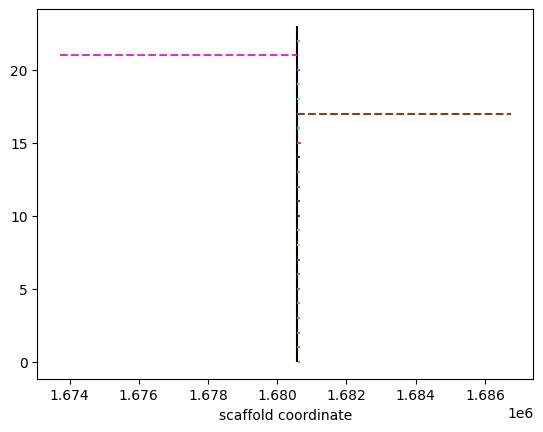

In [69]:
plot('X-21_S81', 'scaffold_10', 1680576.0, 100)

In [71]:
interesting_lines('X-21_S81', 'scaffold_10', 1680576.0, 100)

[['NODE_389_length_26676_cov_34.3035_ID_329304',
  1680581,
  1680651,
  '+',
  26597,
  26667,
  70],
 ['NODE_612_length_13455_cov_78.5913_ID_329746',
  1680582,
  1680651,
  '+',
  10888,
  10957,
  69],
 ['NODE_2813_length_430_cov_68.5609_ID_334138',
  1680583,
  1680651,
  '+',
  0,
  68,
  68],
 ['NODE_720_length_9740_cov_34.8369_ID_329966',
  1680583,
  1680651,
  '+',
  9663,
  9731,
  68],
 ['NODE_901_length_5841_cov_36.3491_ID_330326',
  1680585,
  1680651,
  '+',
  5728,
  5794,
  66],
 ['NODE_129_length_78424_cov_33.3179_ID_328772',
  1680585,
  1680651,
  '+',
  16094,
  16160,
  66],
 ['NODE_3718_length_208_cov_34.4198_ID_335948',
  1680585,
  1680651,
  '+',
  95,
  161,
  66],
 ['NODE_2583_length_509_cov_76.8773_ID_333680',
  1680585,
  1680651,
  '+',
  43,
  109,
  66],
 ['NODE_2560_length_516_cov_76.0137_ID_333634',
  1680585,
  1680651,
  '+',
  51,
  117,
  66],
 ['NODE_111_length_88642_cov_33.7179_ID_328736',
  1680602,
  1680651,
  '+',
  1155,
  1204,
  49],
 ['N

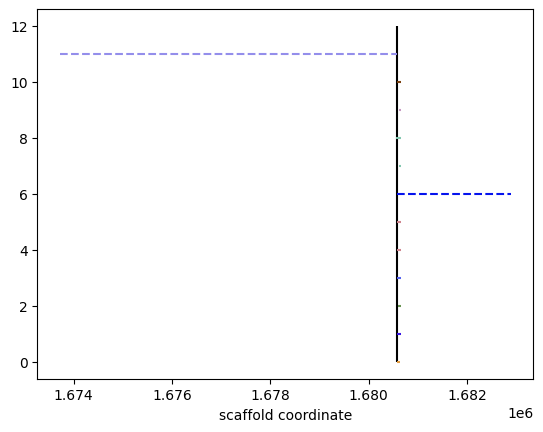

In [70]:
plot('X-44', 'scaffold_10', 1680576.0, 100) 

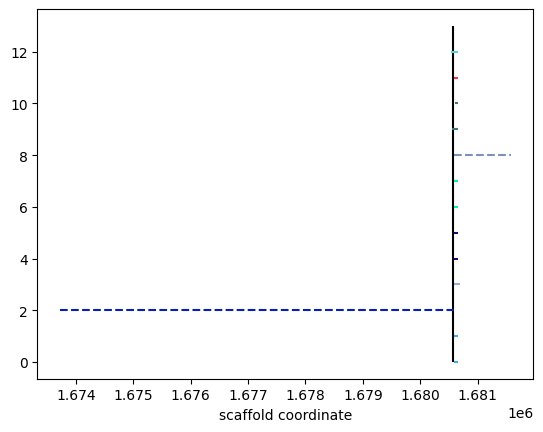

In [72]:
plot('X-27_S82', 'scaffold_10', 1680576.0, 100)

In [74]:
for x in interesting_lines('X-27_S82', 'scaffold_10', 1680576.0, 100):
    if x[1] < 1680576 and x[2] > 1680576:
        print(x)

['NODE_845_length_4695_cov_35.2239_ID_229236', 1680535, 1680651, '+', 4557, 4673, 116]
['NODE_356_length_32108_cov_61.7564_ID_228270', 1680557, 1680651, '+', 9777, 9871, 94]
['NODE_148_length_73588_cov_35.6683_ID_227850', 1673720, 1680583, '-', 3393, 10256, 6863]


# 2

In [75]:
state_df.loc['scaffold_4_2802679.0']

X-21_S81       unclassified
X-44           unclassified
15-14_S76            no inv
A8_contigs     unclassified
M4_contigs        inversion
M5_contigs     unclassified
M6_contigs     unclassified
Mi1_contigs    unclassified
Mos_contigs    rearrangment
X-9_S78        unclassified
X-12_S79       rearrangment
X-17_S80       unclassified
X-27_S82       rearrangment
X-30_S83       unclassified
X-69_S85       unclassified
S1_contigs     rearrangment
S2_contigs     unclassified
S4_contigs     unclassified
14-01_S62            no inv
14-101_S73           no inv
14-102_S74     unclassified
14-104_S75     unclassified
14-112_S77     unclassified
14-11_S63      unclassified
14-24          unclassified
14-25_S64            no inv
14-29_S65      unclassified
14-31_S66      unclassified
14-32_S67      unclassified
14-34_S68      unclassified
14-41                no inv
14-67_S84      unclassified
14-70_S69      unclassified
14-85_S70      unclassified
14-89_S71      unclassified
14-90_S72      uncla

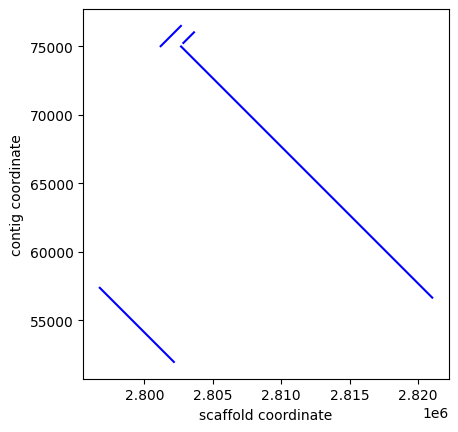

In [81]:
diag_plot('M4_contigs', 'scaffold_4', 2802679.0, 1000)

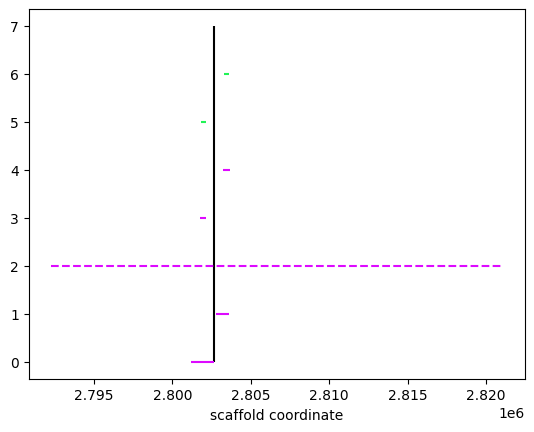

In [86]:
plot('15-14_S76', 'scaffold_4', 2802679.0, 1000)

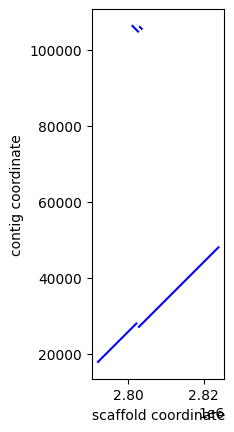

In [88]:
diag_plot('A8_contigs', 'scaffold_4', 2802679.0, 1000)

# 3

In [89]:
state_df.loc['scaffold_10_852816.5']

X-21_S81             no inv
X-44                 no inv
15-14_S76            no inv
A8_contigs     unclassified
M4_contigs           no inv
M5_contigs           no inv
M6_contigs           no inv
Mi1_contigs          no inv
Mos_contigs          no inv
X-9_S78              no inv
X-12_S79             no inv
X-17_S80             no inv
X-27_S82             no inv
X-30_S83             no inv
X-69_S85             no inv
S1_contigs           no inv
S2_contigs           no inv
S4_contigs           no inv
14-01_S62            no inv
14-101_S73           no inv
14-102_S74     rearrangment
14-104_S75           no inv
14-112_S77           no inv
14-11_S63            no inv
14-24                no inv
14-25_S64            no inv
14-29_S65            no inv
14-31_S66            no inv
14-32_S67      unclassified
14-34_S68            no inv
14-41                no inv
14-67_S84            no inv
14-70_S69            no inv
14-85_S70            no inv
14-89_S71            no inv
14-90_S72           

# 4

In [90]:
state_df.loc['scaffold_3_103083.5']

X-21_S81       rearrangment
X-44           rearrangment
15-14_S76      rearrangment
A8_contigs     unclassified
M4_contigs     rearrangment
M5_contigs     rearrangment
M6_contigs     rearrangment
Mi1_contigs    rearrangment
Mos_contigs    rearrangment
X-9_S78           inversion
X-12_S79       rearrangment
X-17_S80       unclassified
X-27_S82       rearrangment
X-30_S83       rearrangment
X-69_S85       rearrangment
S1_contigs     rearrangment
S2_contigs     rearrangment
S4_contigs     rearrangment
14-01_S62      rearrangment
14-101_S73     rearrangment
14-102_S74     rearrangment
14-104_S75     rearrangment
14-112_S77     rearrangment
14-11_S63      rearrangment
14-24               no data
14-25_S64      rearrangment
14-29_S65      rearrangment
14-31_S66      rearrangment
14-32_S67      rearrangment
14-34_S68      rearrangment
14-41          unclassified
14-67_S84      rearrangment
14-70_S69      rearrangment
14-85_S70      rearrangment
14-89_S71      rearrangment
14-90_S72           

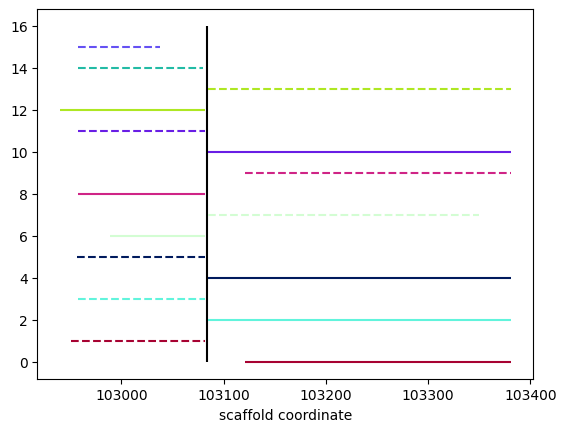

In [93]:
plot('X-9_S78', 'scaffold_3',103083.5, 100)

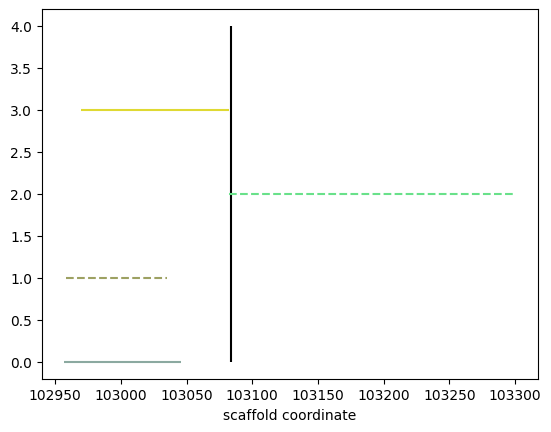

In [98]:
plot('14-41', 'scaffold_3',103083.5, 100)

# 5

In [99]:
state_df.loc['scaffold_4_2967204.0']

X-21_S81       rearrangment
X-44           unclassified
15-14_S76            no inv
A8_contigs           no inv
M4_contigs     rearrangment
M5_contigs     rearrangment
M6_contigs     rearrangment
Mi1_contigs          no inv
Mos_contigs    rearrangment
X-9_S78        rearrangment
X-12_S79       unclassified
X-17_S80       unclassified
X-27_S82       rearrangment
X-30_S83          inversion
X-69_S85       rearrangment
S1_contigs     rearrangment
S2_contigs     rearrangment
S4_contigs     rearrangment
14-01_S62            no inv
14-101_S73           no inv
14-102_S74           no inv
14-104_S75           no inv
14-112_S77           no inv
14-11_S63            no inv
14-24          rearrangment
14-25_S64            no inv
14-29_S65            no inv
14-31_S66            no inv
14-32_S67            no inv
14-34_S68      rearrangment
14-41                no inv
14-67_S84            no inv
14-70_S69            no inv
14-85_S70            no inv
14-89_S71            no inv
14-90_S72      rearr

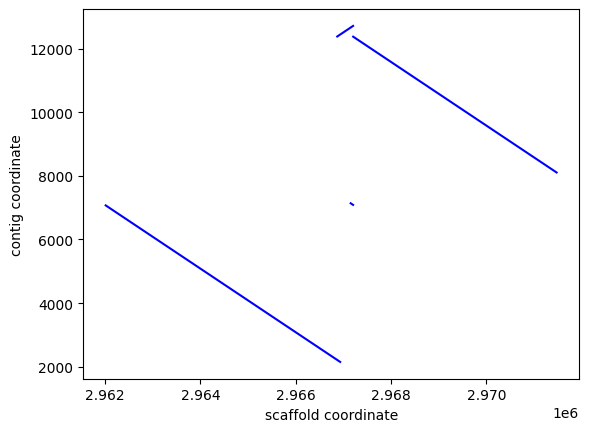

In [117]:
diag_plot('X-30_S83', 'scaffold_4', 2967204.0, 1000, contig_name='NODE_578_length_14456_cov_35.9502_ID_281161', reg=0)

# 6

In [39]:
state_df.loc['scaffold_2_592743.5']

X-21_S81       no inversion
X-44           no inversion
15-14_S76      no inversion
A8_contigs     no inversion
M4_contigs     no inversion
M5_contigs     no inversion
M6_contigs     no inversion
Mi1_contigs    no inversion
Mos_contigs    no inversion
X-9_S78        no inversion
X-12_S79       no inversion
X-17_S80       no inversion
X-27_S82       no inversion
X-30_S83       no inversion
X-69_S85       no inversion
S1_contigs     no inversion
S2_contigs     no inversion
S4_contigs     no inversion
14-01_S62      rearrangment
14-101_S73     rearrangment
14-102_S74     no inversion
14-104_S75     no inversion
14-112_S77     no inversion
14-11_S63      no inversion
14-24             inversion
14-25_S64      no inversion
14-29_S65      no inversion
14-31_S66      unclassified
14-32_S67      no inversion
14-34_S68      rearrangment
14-41          rearrangment
14-67_S84      no inversion
14-70_S69      rearrangment
14-85_S70      rearrangment
14-89_S71      no inversion
14-90_S72      no in

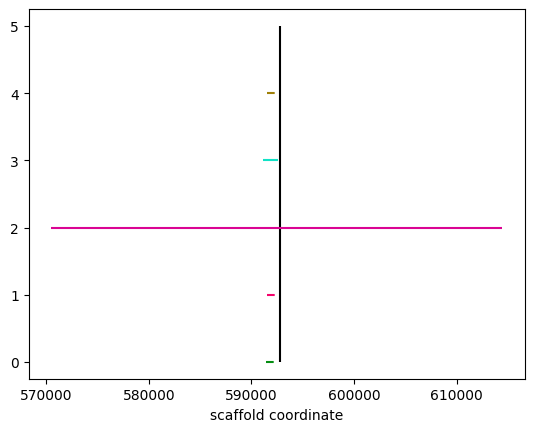

In [44]:
plot('X-21_S81', 'scaffold_2', 592743.5, 1000)

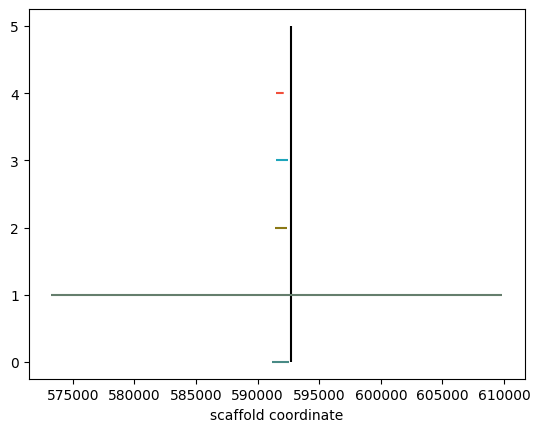

In [45]:
plot('15-14_S76', 'scaffold_2', 592743.5, 1000)

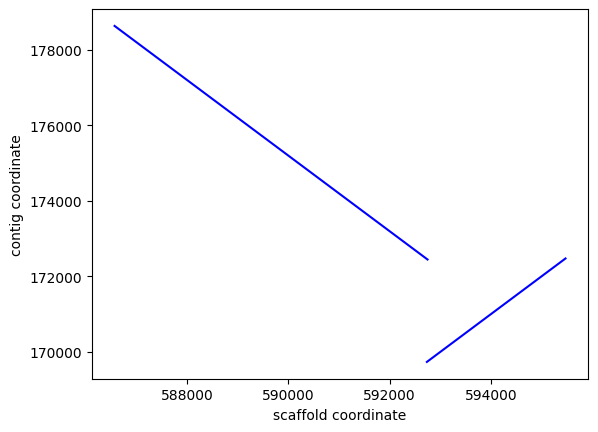

In [52]:
diag_plot('14-24', 'scaffold_2', 592743.5, 1000, reg=0, contig_name='NODE_23_length_351134_cov_109.757527')

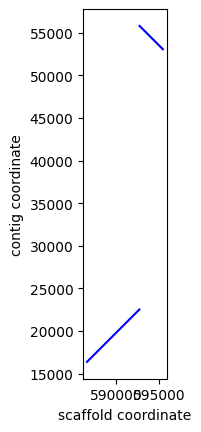

In [54]:
diag_plot('14-34_S68', 'scaffold_2', 592743.5, 1000, contig_name='NODE_143_length_78374_cov_39.6356_ID_196452')

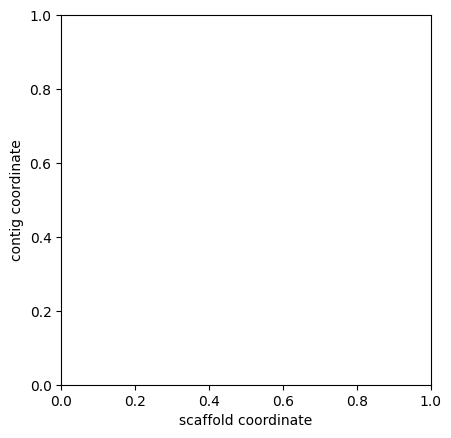

In [56]:
diag_plot('B6_contigs', 'scaffold_2', 592743.5, 1000, contig_name='NODE_143_length_78374_cov_39.6356_ID_196452')

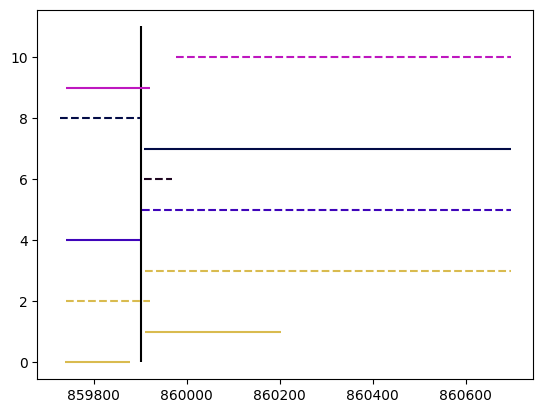

In [132]:
plot('B5_contigs', 'scaffold_3', 859902.0, 100)

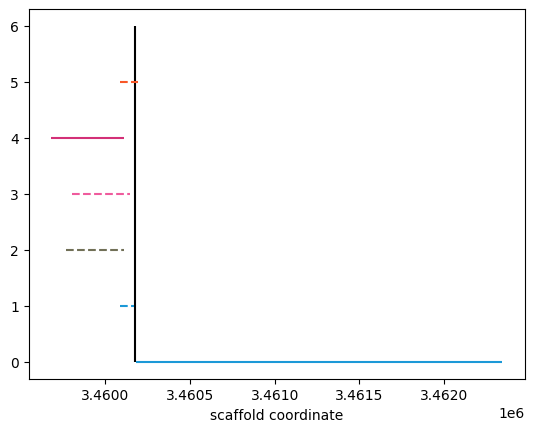

In [29]:
plot('S2_contigs', 'scaffold_4', 3460175.5, 100)

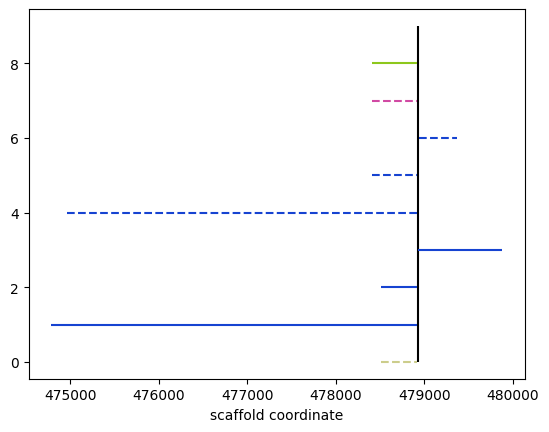

In [30]:
plot('A13_contigs', 'scaffold_12', 478927, 100)

In [53]:
interesting_lines('A13_contigs', 'scaffold_12', 478927, 100)

[['NODE_158_length_68570_cov_14.3537',
  474783,
  478916,
  '+',
  56029,
  60162,
  4133],
 ['NODE_95_length_92200_cov_13.9398', 478409, 478917, '+', 2607, 3115, 508],
 ['NODE_158_length_68570_cov_14.3537', 478508, 478916, '+', 57806, 58214, 408],
 ['NODE_158_length_68570_cov_14.3537', 478931, 479879, '+', 24174, 25122, 948],
 ['NODE_158_length_68570_cov_14.3537',
  474957,
  478916,
  '-',
  24619,
  28578,
  3959],
 ['NODE_219_length_50332_cov_14.2728', 478409, 478917, '-', 666, 1174, 508],
 ['NODE_158_length_68570_cov_14.3537', 478412, 478917, '-', 26165, 26670, 505],
 ['NODE_14_length_195200_cov_13.6596', 478506, 478916, '-', 2985, 3395, 410],
 ['NODE_158_length_68570_cov_14.3537', 478938, 479365, '-', 55620, 56047, 427]]

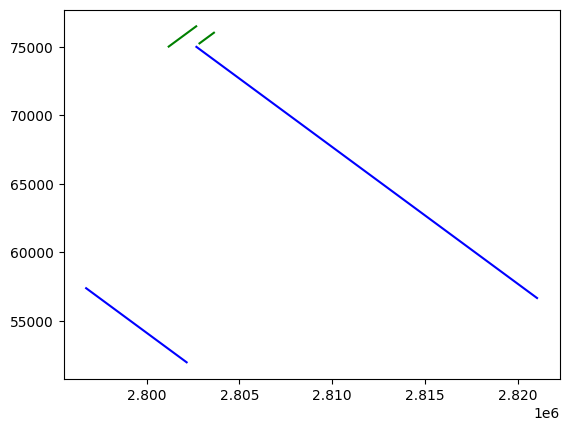

In [96]:
diag_plot('M4_contigs', 'scaffold_4', 2802679.0, 1000)

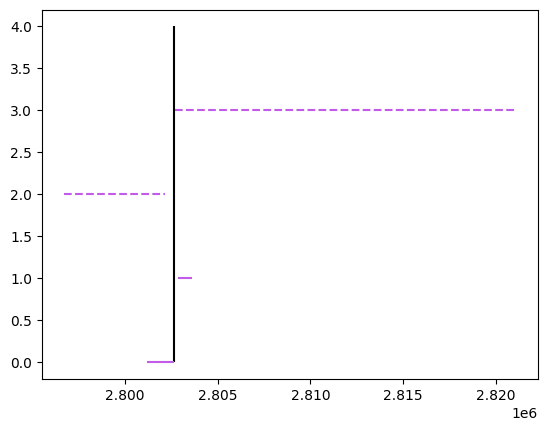

In [48]:
plot('M4_contigs', 'scaffold_4', 2802679, 1000)

In [49]:
interesting_lines('M4_contigs', 'scaffold_4', 2802679, 1000)

[['NODE_61_length_105060_cov_21.8989',
  2801193,
  2802673,
  '+',
  75008,
  76488,
  1480],
 ['NODE_61_length_105060_cov_21.8989',
  2802851,
  2803628,
  '+',
  75243,
  76020,
  777],
 ['NODE_61_length_105060_cov_21.8989',
  2796747,
  2802159,
  '-',
  51949,
  57361,
  5412],
 ['NODE_61_length_105060_cov_21.8989',
  2802685,
  2821029,
  '-',
  56643,
  74987,
  18344]]

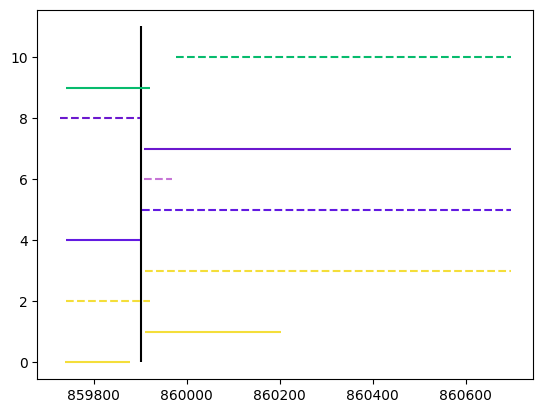

In [50]:
plot('B5_contigs', 'scaffold_3', 859902)

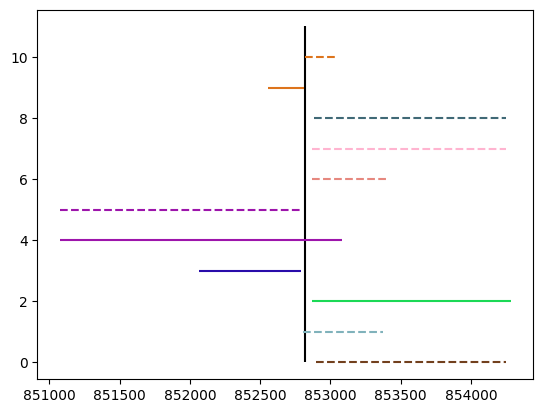

In [51]:
plot('Mi1_contigs', 'scaffold_10', 852816.5)

In [80]:
interesting_lines('Mi1_contigs', 'scaffold_10', 852816.5) #polindrom? 926 causes detection of inversion

[['NODE_540_length_8482_cov_43.6586', 851075, 853081, '+', 2799, 4805, 2006],
 ['NODE_539_length_8489_cov_50.5365', 852066, 852792, '+', 4077, 4803, 726],
 ['NODE_926_length_2018_cov_35.5344', 852556, 852815, '+', 43, 302, 259],
 ['NODE_519_length_9459_cov_43.524', 852866, 854284, '+', 5732, 7150, 1418],
 ['NODE_540_length_8482_cov_43.6586', 851079, 852796, '-', 264, 1981, 1717],
 ['NODE_1554_length_642_cov_45.9898', 852808, 853376, '-', 59, 627, 568],
 ['NODE_926_length_2018_cov_35.5344', 852818, 853057, '-', 307, 546, 239],
 ['NODE_674_length_4817_cov_76.9933', 852872, 853410, '-', 4151, 4689, 538],
 ['NODE_771_length_3269_cov_161.909', 852872, 854248, '-', 1809, 3185, 1376],
 ['NODE_889_length_2320_cov_98.294', 852884, 854248, '-', 862, 2226, 1364],
 ['NODE_1042_length_1479_cov_34.9199', 852898, 854247, '-', 0, 1349, 1349]]

# -1 no inversion

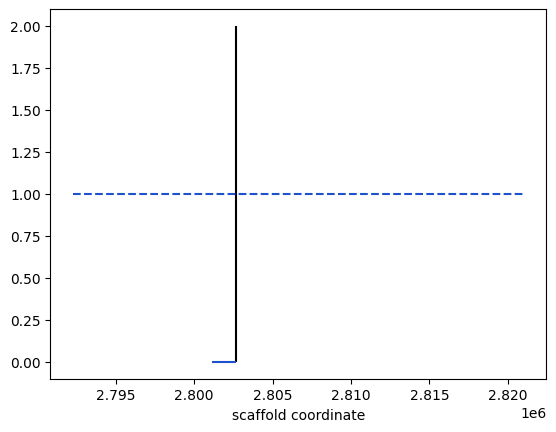

In [31]:
plot('15-14_S76', 'scaffold_4', 2802679)

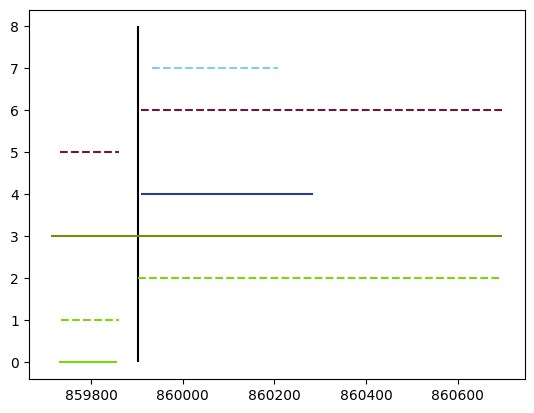

In [82]:
plot('X-30_S83', 'scaffold_3', 859902)

In [83]:
interesting_lines('X-30_S83', 'scaffold_3', 859902)

[['NODE_186_length_60535_cov_37.2484_ID_280379',
  859713,
  860697,
  '+',
  860,
  1844,
  984],
 ['NODE_110_length_87557_cov_37.372_ID_280223',
  859730,
  859856,
  '+',
  59470,
  59596,
  126],
 ['NODE_1932_length_692_cov_113.003_ID_283867',
  859910,
  860285,
  '+',
  335,
  710,
  375],
 ['NODE_377_length_28233_cov_38.2672_ID_280767',
  859732,
  859860,
  '-',
  24954,
  25082,
  128],
 ['NODE_110_length_87557_cov_37.372_ID_280223',
  859734,
  859860,
  '-',
  27280,
  27406,
  126],
 ['NODE_110_length_87557_cov_37.372_ID_280223',
  859903,
  860697,
  '-',
  27280,
  28074,
  794],
 ['NODE_377_length_28233_cov_38.2672_ID_280767',
  859910,
  860697,
  '-',
  24963,
  25750,
  787],
 ['NODE_725_length_9577_cov_75.4583_ID_281455',
  859933,
  860208,
  '-',
  8919,
  9194,
  275]]

# 2 rearrangement (no inversion)
looks like inversion, but contig coordinates are not close

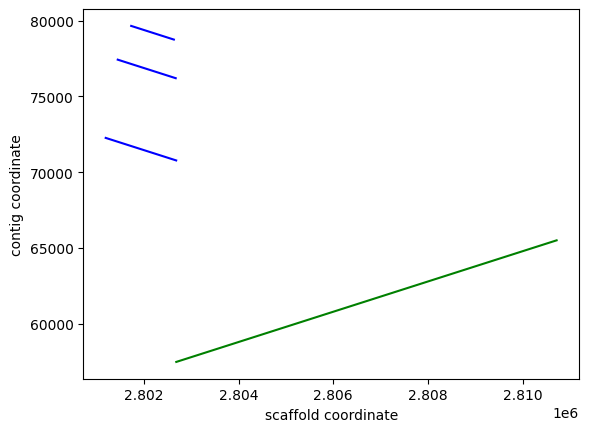

In [33]:
diag_plot('Mos_contigs', 'scaffold_4', 2802679)

In [85]:
interesting_lines('Mos_contigs', 'scaffold_4', 2802679)

[['NODE_56_length_106057_cov_25.8178',
  2802685,
  2810714,
  '+',
  57469,
  65498,
  8029],
 ['NODE_56_length_106057_cov_25.8178',
  2801195,
  2802683,
  '-',
  70775,
  72263,
  1488],
 ['NODE_56_length_106057_cov_25.8178',
  2801449,
  2802673,
  '-',
  76206,
  77430,
  1224],
 ['NODE_56_length_106057_cov_25.8178',
  2801733,
  2802634,
  '-',
  78757,
  79658,
  901]]

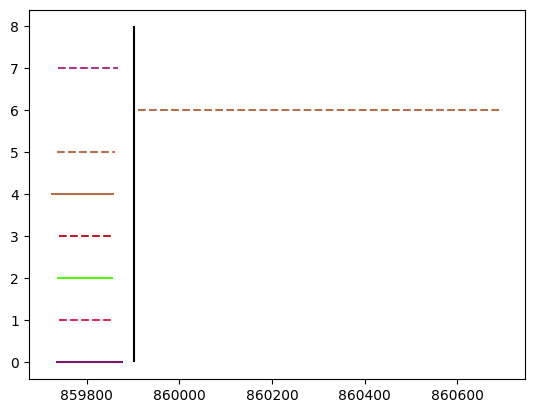

In [86]:
plot('X-12_S79', 'scaffold_3', 859902)

In [87]:
interesting_lines('X-12_S79', 'scaffold_3', 859902)

[['NODE_654_length_9255_cov_146.52_ID_262659',
  859723,
  859859,
  '+',
  6483,
  6619,
  136],
 ['NODE_154_length_70471_cov_51.5662_ID_261649',
  859734,
  859879,
  '+',
  70213,
  70358,
  145],
 ['NODE_395_length_24927_cov_50.0353_ID_262139',
  859736,
  859856,
  '+',
  24807,
  24927,
  120],
 ['NODE_654_length_9255_cov_146.52_ID_262659',
  859735,
  859860,
  '-',
  1963,
  2088,
  125],
 ['NODE_709_length_7827_cov_50.1639_ID_262767',
  859738,
  859868,
  '-',
  7232,
  7362,
  130],
 ['NODE_549_length_14049_cov_64.6648_ID_262443',
  859741,
  859853,
  '-',
  4981,
  5093,
  112],
 ['NODE_392_length_25194_cov_49.8153_ID_262133',
  859741,
  859853,
  '-',
  24667,
  24779,
  112],
 ['NODE_654_length_9255_cov_146.52_ID_262659',
  859910,
  860697,
  '-',
  1969,
  2756,
  787]]

# 0 Can't tell anything

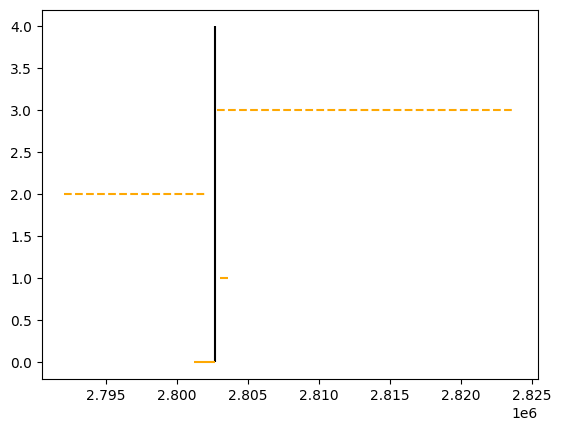

In [88]:
plot('14-70_S69', 'scaffold_4', 2802679, 1000)

In [89]:
interesting_lines('14-70_S69', 'scaffold_4', 2802679, 1000)

[['NODE_4_length_520094_cov_48.8621_ID_191557',
  2801197,
  2802673,
  '+',
  383849,
  385325,
  1476],
 ['NODE_4_length_520094_cov_48.8621_ID_191557',
  2803071,
  2803628,
  '+',
  384498,
  385055,
  557],
 ['NODE_4_length_520094_cov_48.8621_ID_191557',
  2792093,
  2802165,
  '-',
  149417,
  159489,
  10072],
 ['NODE_4_length_520094_cov_48.8621_ID_191557',
  2802876,
  2823845,
  '-',
  158610,
  179579,
  20969]]

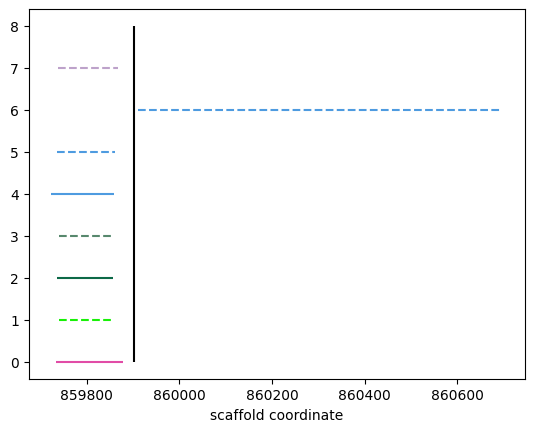

In [36]:
plot('X-12_S79', 'scaffold_3', 859902, 100)

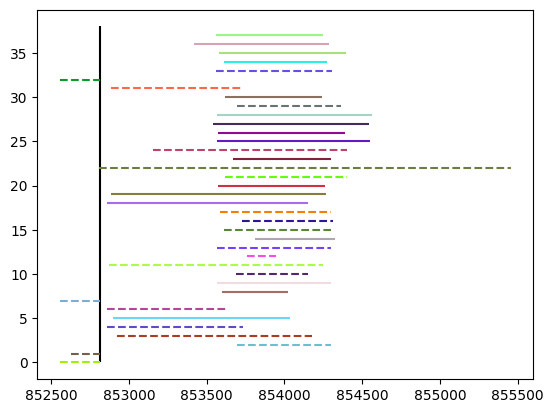

In [91]:
plot('A8_contigs', 'scaffold_10', 852816.5, 1000)

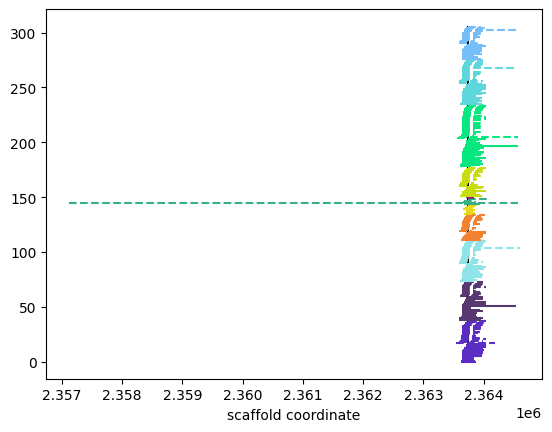

In [130]:
plot('X-21_S81', 'scaffold_1', 2363741, 10) 

In [131]:
interesting_lines('X-21_S81', 'scaffold_1', 2363741, 10) 

[['NODE_1039_length_4127_cov_31.5432_ID_330594',
  2363586,
  2363950,
  '+',
  1832,
  2196,
  364],
 ['NODE_1039_length_4127_cov_31.5432_ID_330594',
  2363593,
  2363840,
  '+',
  1988,
  2235,
  247],
 ['NODE_1039_length_4127_cov_31.5432_ID_330594',
  2363595,
  2363986,
  '+',
  1830,
  2221,
  391],
 ['NODE_861_length_6804_cov_45.9631_ID_330248',
  2363598,
  2363793,
  '+',
  5983,
  6178,
  195],
 ['NODE_1585_length_1447_cov_40.5898_ID_331688',
  2363598,
  2363834,
  '+',
  1163,
  1399,
  236],
 ['NODE_861_length_6804_cov_45.9631_ID_330248',
  2363603,
  2363934,
  '+',
  5829,
  6160,
  331],
 ['NODE_918_length_5596_cov_30.898_ID_330360',
  2363606,
  2363968,
  '+',
  564,
  926,
  362],
 ['NODE_745_length_9060_cov_30.8232_ID_330020',
  2363606,
  2363962,
  '+',
  198,
  554,
  356],
 ['NODE_861_length_6804_cov_45.9631_ID_330248',
  2363626,
  2363979,
  '+',
  5805,
  6158,
  353],
 ['NODE_1635_length_1322_cov_59.8096_ID_331788',
  2363626,
  2363953,
  '+',
  1003,
  1330

In [20]:
def get_data_seq(mushroom_name):
    names_of_scaffolds = []
    for i in range(1, 26):
        names_of_scaffolds.append('scaffold_' + str(i)) 


    filename = 'ref_' + mushroom_name + '.maf'
    with open(filename) as fin:
        fin.seek(0) #395
        data = fin.read()
    data = data.split('\n')
    for i in range(len(data)):
        del data[0]
        if data[0] == '':
            del data[0]
            break

    lines = []
    pos_start = 0
    for x in data:
        lines.append(x.split())
    good_lines = {}
    lines = [x for x in lines if x != []] 
    for i in range(len(lines)):
        if lines[i][0] == 'a':
            scaf_name = lines[i+1][1]
            pos_start, length = lines[i+1][2], lines[i+1][3]
            if scaf_name not in good_lines.keys():
                good_lines[scaf_name] = []
        else:
            lines[i].append(pos_start)
            lines[i].append(length)
            good_lines[scaf_name].append(lines[i])
    data_fin = {}
    for name_of_scaffold in names_of_scaffolds:
        if name_of_scaffold in good_lines.keys():
            res = good_lines[name_of_scaffold]

            # leaving only necessary information
            data_fin_sc = []
            for x in res:
                if x[1].startswith('NODE'):
                    data_fin_sc.append([x[1], int(x[-2]), int(x[-2]) + int(x[-1]), x[4], int(x[2]), int(x[2]) + int(x[-1]), int(x[-1]), x[-3]])
            data_fin[name_of_scaffold] = data_fin_sc
    return data_fin

In [21]:
def interesting_lines_seq(m, sc, coord, num=100):
    data = get_data_seq(m)
    int_lines = []
    for line in data[sc]:
        if ((coord > int(line[1]) + 30) and coord < (int(line[2]) - 30)) or abs(coord - line[1]) < num or abs(coord - line[2]) < num:
            if line not in int_lines:
                int_lines.append(line)
    return int_lines

interesting_lines_seq('X-21_S81', 'scaffold_1', 2363741, 10) 

In [64]:
filename = 'ref_' + '14-24' + '.maf'
with open(filename) as fin:
    fin.seek(0) #395
    data = fin.read()


In [65]:
data